In [1]:
# load libraries
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# load business detail dataframe
yelp_business = pd.read_pickle('data/df_business_details.pkl')

In [3]:
# filter out only relevant features
# categories, coordinates, is_closed, location, price, rating, review_count
filtered_yelp = yelp_business[['categories', 'coordinates', 'is_closed',
                               'location', 'price', 'rating', 'review_count']]

In [4]:
# turn data types into usable ones
display(filtered_yelp.dtypes)
# filtered_yelp.head()

categories       object
coordinates      object
is_closed          bool
location         object
price            object
rating          float64
review_count      int64
dtype: object

In [5]:
# check for na values
filtered_yelp.isnull().any()  
# null value in price

categories      False
coordinates     False
is_closed       False
location        False
price            True
rating          False
review_count    False
dtype: bool

In [6]:
# check for rows and column nums
filtered_yelp.shape

(6754, 7)

In [7]:
# split lat and lon into 2 separate columns
# noticed certian coordinates with zero na for lat and lon 
filtered_yelp['Lat'] = filtered_yelp.coordinates.apply(lambda x: x['latitude'])
filtered_yelp['Lon'] = filtered_yelp.coordinates.apply(
    lambda x: x['longitude'])

In [8]:
# noticed na values in Lat and Lon 
filtered_yelp.isnull().any() 
# NA in price and Lat and Lon will investigate later 

categories      False
coordinates     False
is_closed       False
location        False
price            True
rating          False
review_count    False
Lat              True
Lon              True
dtype: bool

In [9]:
# add column for state to split location info into DC, MD, VA
states = filtered_yelp.location.apply(lambda x: x['state'])
filtered_yelp['state'] = states
# check unique states
filtered_yelp.state.unique()  # some chain restaurants may be included

array(['MD', 'VA', 'DC', 'TN', 'KS', 'NDN', 'MN', 'UT', 'OH', 'NLN', 'CA',
       'MO', 'GA', 'IL', 'XGM', 'AL', 'AZ', 'LA', 'NE', 'TX'],
      dtype=object)

In [10]:
# filter out only states for VA, MD, and DC
filtered_yelp = filtered_yelp[(filtered_yelp['state'] == 'VA') | (
    filtered_yelp['state'] == 'MD') | (filtered_yelp['state'] == 'DC')]

In [11]:
# check for rows and column nums
filtered_yelp.shape

(6728, 10)

In [12]:
# check for how many price is null
sum(filtered_yelp.price.isnull())
# we will not remove but replace no price with median price
# as we want to keep round dollar sign

1028

In [13]:
# convert $ sign into num of $ for non na values
filtered_yelp.price[~filtered_yelp.price.isnull(
)] = filtered_yelp.price[~filtered_yelp.price.isnull()].apply(lambda x: len(x))
median_price = filtered_yelp.price.median()
filtered_yelp.price[filtered_yelp.price.isnull()] = median_price

In [14]:
# recheck for na to make sure 
sum(filtered_yelp.price.isnull())

0

In [15]:
# check for variable for is closed
filtered_yelp.groupby('is_closed').size()
# all are closed so no need for that column
filtered_yelp.drop(columns=['is_closed'], inplace=True)

In [16]:
# convert category column to a string with combo category with | symbol
s = '|'
filtered_yelp['categories'] = filtered_yelp.categories.apply(
    lambda x: s.join([t['title'] for t in x]))

In [17]:
# check for na in coordinates for lat and lon
# some rows lat and lon for coordiantes is nan in dictionary 
filtered_yelp.isnull().any()
sum(filtered_yelp.Lat.isnull())
# only 31, we will keep the rows and remove later 
# it can be used for mapping 

31

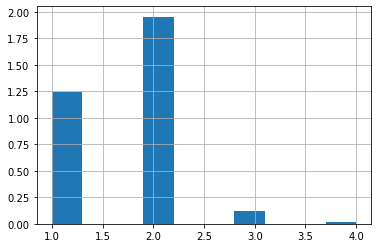

In [18]:
# price distribution as exploratory analysis
filtered_yelp.price.hist(density=True)
plt.show()
# mostly around 2 dollar signs

<BarContainer object of 3 artists>

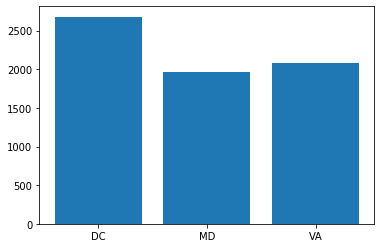

In [19]:
# check for location for restaurant count as eda
plt.bar(x=filtered_yelp.groupby('state').size().index,
        height=filtered_yelp.groupby('state').size())

In [20]:
# top 5 most common restaurant categories
filtered_yelp.groupby('categories').size().sort_values(ascending=False)[:5]

categories
Chinese                 231
Pizza                   204
Sandwiches|Fast Food    148
Mexican                 111
American (New)           98
dtype: int64

In [21]:
# remove coordinates, location as no longer useful
yelp_price_location = filtered_yelp.drop(columns=['coordinates', 'location'])

In [22]:
# make sure no duplicated
# couldn't earlier due to dictionary as row values
yelp_price_location.duplicated().any()

False

In [23]:
# final look at the cleaned table before cleaning
yelp_price_location.head()

,categories,price,rating,review_count,Lat,Lon,state
0,Salad|Seafood|American (Traditional),2,3.5,372,38.997397,-77.026797,MD
1,Pizza|American (New)|Salad,2,3.5,192,38.919506,-77.224311,VA
2,Breakfast & Brunch|American (Traditional)|Burgers,2,2.5,125,39.014190,-76.928270,MD
3,Seafood,1,4.0,13,38.854145,-76.897896,MD
4,Donuts|Coffee & Tea|Breakfast & Brunch,1,4.5,2,38.790540,-77.076455,VA


In [24]:
# save cleaned dataframe for Location and Price hypothesis
yelp_price_location.to_pickle('data/yelp_price_location.pkl')